# Equação de onda elástica em 1-D (Chebyshev Pseudoespectral)

Este notebook descreve a solução numérica  da equação de onda elástica em 1-D, com o uso do Método de Chebyshev Pseudoespectral. A equação a simular é da forma: 

\begin{equation}
\rho(x) \frac{\partial^2 u(x,t)}{\partial t^2} = \frac{\partial}{\partial x} \left(\mu(x) \frac{\partial u(x,t)}{\partial x} \right) + f(x,t),
\end{equation}

e usamos um operador de  diferenças finitas com stencil de 3 pontos para aproximar as derivadas temporais. O campo de deslocamento é então extrapolado como:
\begin{equation}
\rho_i\frac{u_{i}^{j+1} - 2u_{i}^{j} + u_{i}^{j-1}}{dt^2}= \frac{\partial}{\partial x} \left(\mu(x) \frac{\partial u(x,t)}{\partial x} \right)_{i}^{j} + f_{i}^{j}
\end{equation}

Um modo alternativo de calcular as derivadas no espaço de uma função definida nos pontos de colocação de Chebyshev é definir uma matriz derivada $D_{ij}$

$$
D_{ij} =
  \begin{cases}
    -\frac{2 N^2 + 1}{6} \;\; \;\;  \text{para}\;\;  i  = j = N\\
    -\frac{1}{2} \frac{x_i}{1-x_i^2} \;\; \;\;  \text{para}\;\; i = j = 1,2,\ldots,N-1\\
    \frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i - x_j} \;\; \;\;  \text{para} \;\; i \neq j = 0,1,\ldots,N
  \end{cases}
$$

onde $N+1$ é o número de pontos de colocação de Chebyshev $ \ x_i = cos(i\pi / N)$, $ \ i=0,\ldots,N$ e os coeficientes $c_i$ são dados por:

$$ c_i = 2 \;\;\;\;\;\;\; \text{para}\;\;  i  = 0 \;\; \text{ou} \;\;N $$
$$ c_i = 1 \;\;\;\;\;\;\;\; \text{de outro modo} $$

Esta matriz de diferenciação permite-nos escrever a derivada da função $f_i = f(x_i)$ (possivelmente dependente do tempo) simplesmente como:

$$\partial_x u_i = D_{ij} \ u_j$$

onde o lado direito é um produto matriz-vector,  e estamos a usar a convenção de Einstein da soma sobre índices repetidos.


In [3]:
# Configuração
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Import python function from the file "ricker.py"
# -----------------------
from ricker import ricker 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 1. Método da derivada de Chebyshev

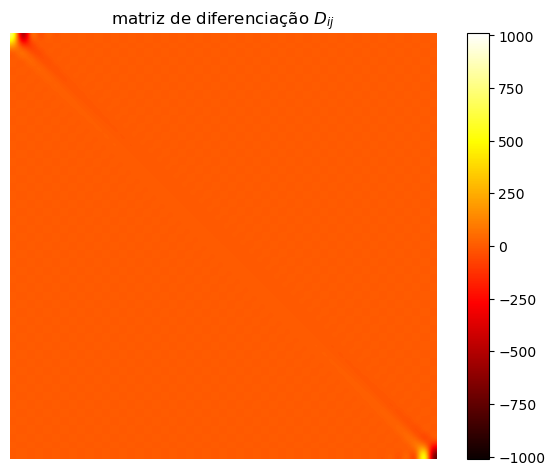

In [5]:
# Definir função que inicializa a matriz derivada de Chebyshev D_{ij} 
def get_cheby_matrix(nx):
    cx = np.zeros(nx+1)
    x = np.zeros(nx+1)
    for ix in range(0,nx+1):
        x[ix] = np.cos(np.pi * ix / nx)
   
    cx[0] = 2.
    cx[nx] = 2.
    cx[1:nx] = 1.
   
    D = np.zeros((nx+1,nx+1))
    for i in range(0, nx+1):
        for j in range(0, nx+1):
            if i==j and i!=0 and i!=nx:
                D[i,i]=-x[i]/(2.0*(1.0-x[i]*x[i]))
            else:
                D[i,j]=(cx[i]*(-1)**(i+j))/(cx[j]*(x[i]-x[j]))
  
    D[0,0] = (2.*nx**2+1.)/6.
    D[nx,nx] = -D[0,0]
    return D 

# criar uma matriz derivada de Chebyshev como exemplo
# ---------------------------------------------------------------
D_ij = get_cheby_matrix(50)

# ---------------------------------------------------------------
# Mostrar graficamente a matriz de diferenciação
# ---------------------------------------------------------------
plt.imshow(D_ij, interpolation="bicubic", cmap="hot")
plt.title('matriz de diferenciação $D_{ij}$')
plt.axis("off")
plt.tight_layout()
plt.colorbar()
plt.show()

### 2. Inicialização

In [10]:
# Parâmetros básicos
# ---------------------------------------------------------------
#nt = 5000        # número de passos no tempo
tmax  = 0.0006
eps   = 1.4       # limite de estabilidade
isx   = 100
lw    = 0.7
ft    = 10
f0    = 100000    # frequência principal
iplot = 20        # frequência de plot

# Parâmetros do material
rho = 2500.
c   = 3000.
mu  = rho*c**2

# domínio espacial
nx = 100     # número de pontos da grelha espacial em x
xs = np.floor(nx/2)      # poosição da fonte
xr = np.floor(nx*0.8)
x  = np.zeros(nx+1) 

# initialização dos campos
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 

for ix in range(0,nx+1):
    x[ix] = np.cos(ix * np.pi / nx) 
dxmin = min(abs(np.diff(x)))
dxmax = max(abs(np.diff(x)))

dt = eps*dxmin/c    # calcular o passo temporal do critério de estabilidade
nt = int(round(tmax/dt))

### 3. Initialização da fonte

In [11]:
# função fonte no tempo
# ---------------------------------------------------------------
t = np.arange(1, nt+1)*dt  # inicializar o eixo dos tempos
T0 = 1./f0
tmp = ricker(dt, T0)
isrc = tmp
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp

# função fonte no espaço
# ---------------------------------------------------------------
sigma = 1.5*dxmax
x0 = x[int(xs)]
sg = np.exp(-1/sigma**2*(x-x0)**2)
sg = sg/max(sg) 

### 4. Extrapolação no tempo

Agora estrapolamos no tempo usando o método antes definido get_cheby_matrix(nx) para obter a matriz de diferenciação. Os valores discretos da simulação podem ser mostrados no plor como pontos, para evidenciar como os pontos de colocação de Chebyshev não são equidistantes. Nota-se facilmente que são mais concentrados nas extremidades do domínio.

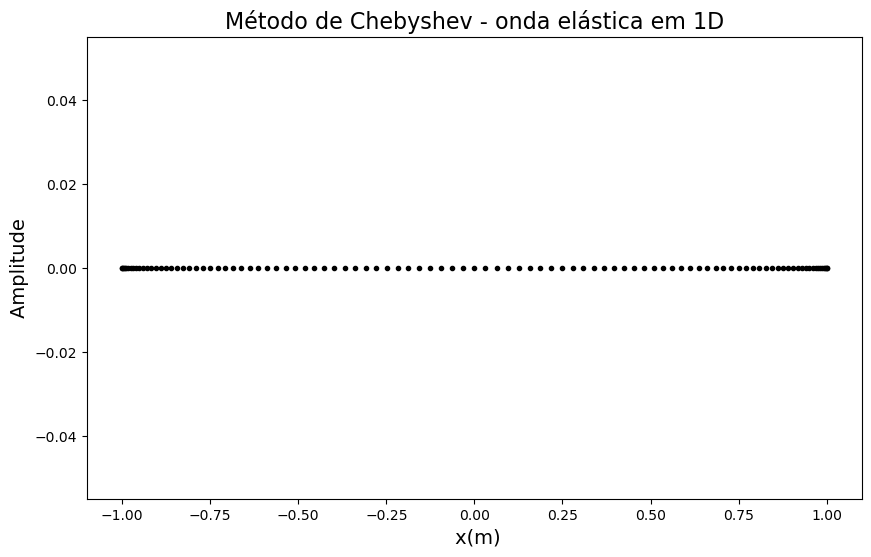

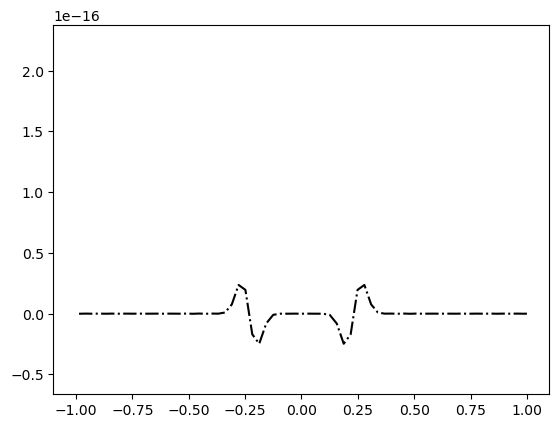

In [12]:
# Inicializar a animação
# ---------------------------------------------------------------
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)
plt.title('Método de Chebyshev - onda elástica em 1D', size=16)
plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)

plt.ion() # ligar modo interactivo
plt.show()
# ---------------------------------------------------------------
# Extrapolação no tempo
# ---------------------------------------------------------------
# matriz de diferenciação
D = get_cheby_matrix(nx)
for it in range(nt):
    # derivadas espaciais
    dp = np.dot(D, p.T)
    dp = mu/rho * dp
    dp = D @ dp
    
    # Extrapolação no tempo 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # inserir fonte
    pnew = pnew + sg*src[it]*dt**2/rho
    
    # Redefinir campos
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # aplicar condições fronteira (Dirichlet) 

    # --------------------------------------   
    # plot para animação. Display solução
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display linhas
        line = plt.plot(x, p, 'k-.', lw=1.5)
        plt.gcf().canvas.draw()